In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


In [9]:
a = np.linspace(0, 31, 32)
b = a - 15.5
c = np.zeros((32, 32))

for i in range(32):
    for j in range(32):
        if (i - 15.5) ** 2 + (j - 15.5) ** 2 < 16 ** 2:
            c[i, j] = 1

print(c)
# plt.imshow(c)
d = torch.tensor(c)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


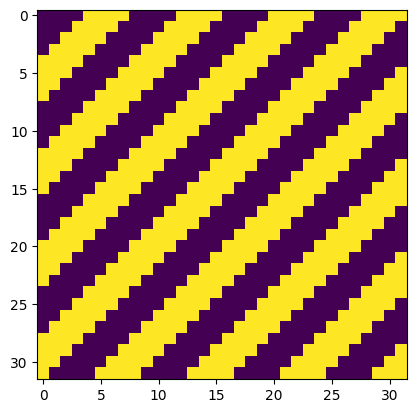

In [25]:
zero = np.zeros((32, 32))

for i in range(32):
    for j in range(32):
        # if ((i + j)) % 2: zero[i, j] = 1
        if ((i + j) // 4) % 2: zero[i, j] = 1
        # if ((i + j)) % 8 < 4: zero[i, j] = 1

plt.imshow(zero)

In [55]:
def grid_alt(k):
    zero = np.zeros((32, 32))

    for i in range(32):    
        for j in range(32):
            if ((i // k) % 2 + (j // k) % 2) % 2: zero[i, j] = 1
    zero = torch.from_numpy(zero)
    t = torch.stack([zero, zero, zero])
    return t

def grid_cir(r):
    c = np.zeros((32, 32))

    for i in range(32):
        for j in range(32):
            if (i - 15.5) ** 2 + (j - 15.5) ** 2 < r ** 2:
                c[i, j] = 1
    c = torch.from_numpy(c)
    t = torch.stack([c, c, c])
    return t



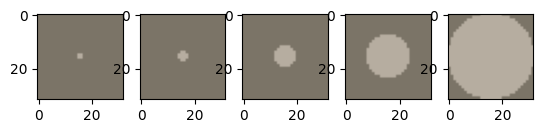

In [56]:
li = [1, 2, 4, 8, 16]
new = []
for i in li:
    new.append(grid_cir(i))
new = torch.stack(new)

fig, axes = plt.subplots(1, 5)
axes_flat = axes.flat
for i in range(5):
    ax = next(axes_flat)
    ax.imshow(convert_to_img(new[i]))

torch.save(new, '/home/dhlee/code/ig_inversion/ten/grid_cir.pt')

In [59]:
baseline = torch.load('/home/dhlee/code/ig_inversion/ten/grid_cir.pt', map_location='cpu')
temp = baseline[0]
temp

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64)

In [53]:
torch.save(new, '/home/dhlee/code/ig_inversion/ten/grid_alt.pt')

In [ ]:
import torchvision.transforms as T
CIFAR10_STATS = {
    'mean' : [0.4914, 0.4822, 0.4465],
    'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])

valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked/', train=False, transform=transform)
# valid_dataset = torchvision.datasets.CIFAR10(root='/root/data/cifar10', train=False, transform=transform)
# interpolation = torch.from_numpy(np.load('/root/results/cifar10/image_simple_gradient_ascent_interpolation.npy'))

# interpolation.shape
model = torch.load("/data8/donghun/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to(device)
# model = torch.load("/root/data/cifar10/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to('cuda:0')
